In [1]:
import warnings
warnings.filterwarnings('ignore')
import altair as alt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

1. Предварительная обработка данных:  
— Очистите данные от пропусков (если они есть), обработайте аномалии и нормализуйте данные, если это необходимо.  
— Разделите датасет на обучающую и тестовую выборки.  

In [2]:
df = pd.read_csv('diabetes-dataset.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2000.0,3.70350,3.306063,0.000,1.000,3.000,6.000,17.00
Glucose,2000.0,121.18250,32.068636,0.000,99.000,117.000,141.000,199.00
BloodPressure,2000.0,69.14550,19.188315,0.000,63.500,72.000,80.000,122.00
SkinThickness,2000.0,20.93500,16.103243,0.000,0.000,23.000,32.000,110.00
Insulin,2000.0,80.25400,111.180534,0.000,0.000,40.000,130.000,744.00
BMI,2000.0,32.19300,8.149901,0.000,27.375,32.300,36.800,80.60
DiabetesPedigreeFunction,2000.0,0.47093,0.323553,0.078,0.244,0.376,0.624,2.42
Age,2000.0,33.09050,11.786423,21.000,24.000,29.000,40.000,81.00
Outcome,2000.0,0.34200,0.474498,0.000,0.000,0.000,1.000,1.00


In [5]:
df.isna().sum()

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


Мы видим, что в датафрейме нет пропусков, однако при просмотре таблицы я заметил, что в столбцах BloodPressure, SkinThickness, Insulin стоит значение ноль, хотя рационально понятно, что у живого человека эти показатели не могут быть равны нулю, видимо, 0 ставили, если исследование не проводилось.  
По этой же причине мы видим, что у 50% пациенток из выборки толщина кожной складки от 0 до 32 мм и уровень инсулина от 0 до 130. Мы также видим, что параметры содержание глюкозы, ИМТ, давление (как заметили при просмотре таблицы) принимают значение 0, что невозможно. Эти нули однозначно исказят данные для модели. Проставить NaN мы не можем - модель не воспринимает NaN. Следует принять решение, что же делать с данными.

In [6]:
nulls = len(df[(df.BloodPressure == 0)]) + len(df[(df.Insulin == 0)]) + len(df[(df.SkinThickness == 0)]) + len(df[(df.Glucose == 0)]) + len(df[(df.BMI == 0)])
nulls

1660

Таких пропущенных значений в сумме довольно много, просто удалить мы их не можем. Это почти весь объем данных.

In [7]:
print(len(df[(df.Glucose == 0)]))
print(len(df[(df.BMI == 0)]))
print(len(df[(df.BloodPressure == 0)]))


13
28
90


Предалаю удалить строки, где мы встретили данные пропуски, так как их довольно мало.

In [8]:
df.drop(df[(df['Glucose'] == 0) | (df['BMI'] == 0) | (df['BloodPressure'] == 0)].index, inplace=True)

In [9]:
print(len(df[(df.SkinThickness == 0)]))
print(len(df[(df.Insulin == 0)]))

488
851


Столбец "толщина кожи" содержит примерно четверть пропусков. Предлагаю его заполнить средним значением. А, к сожалению, в столбце, отражающем содержание инсулина в крови, пропусков - почти половина, если заполнить его средними значениями, мы совсем исказим зависимость, поэтому данный столбец, хоть он и показателен (судя по графикам, которые я строила для себя), придется удалить совсем.

In [10]:
df['SkinThickness'].replace(0, np.nan, inplace=True)
df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace=True)
df = df.drop(['Insulin'], axis=1)

In [11]:
len(df)

1888

In [12]:
duplicates = df.duplicated()
duplicates.sum()

1186

В таблице как будто бы есть дубли, однако теоретически данные могут и повторяться, у нас нет каких-то индивидуальных параметров.

<Axes: ylabel='Outcome'>

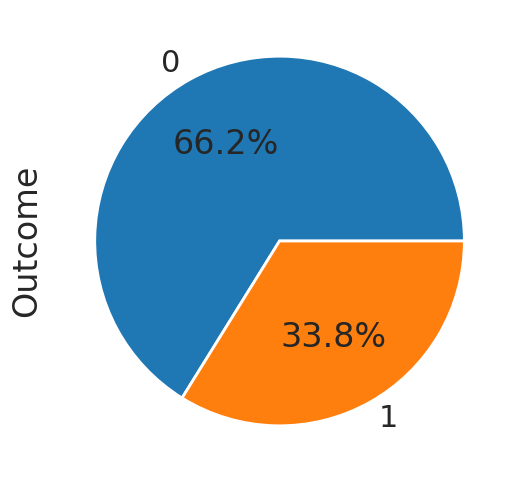

In [13]:
sns.set_style('darkgrid')
sns.set_context('poster')
plt.rcParams['figure.figsize'] = [8,6]
df.groupby('Outcome').size().plot(kind='pie',
                                       y = "Outcome",
                                       label = "Outcome",
                                       autopct='%1.1f%%')

Целевая колонка - есть диабет или нет - находится в добольно выраженном дисбалансе.У 66 % испытуемых не обнаружили диабет, а у 34% - обнаружили.
Данную колонку я оцениваю как качественный признак, остальные - как количественные.

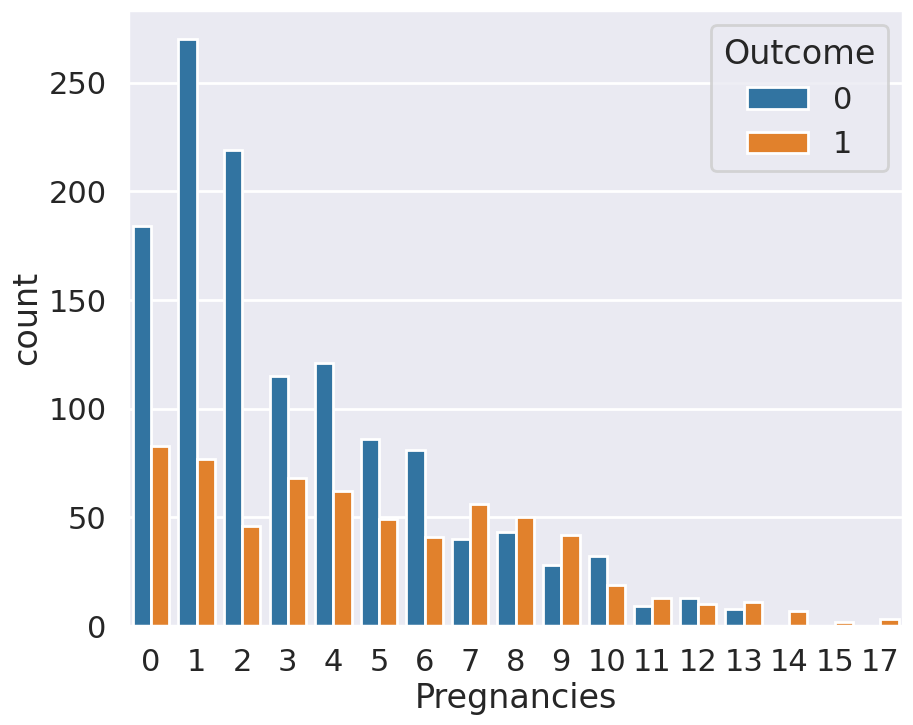

In [14]:
plt.figure(figsize=(10,8))
sns.countplot(x='Pregnancies',hue='Outcome',data=df)
plt.show()

Имеющиеся у нас данные не очень подходят для такой визуализации. Мы видим, что у женщин, у которых была 1 беременность, реже всего обнаруживали диабет. При этом чаще всего диабет обнаруживается у женщин (мы знаем, что в исследовании принимали участие только женщины), перенесших 0 или 1 беременность. Полагаю, чаще всего женщины и испытывают всего 0 или 1 беременность, их просто больше всего.

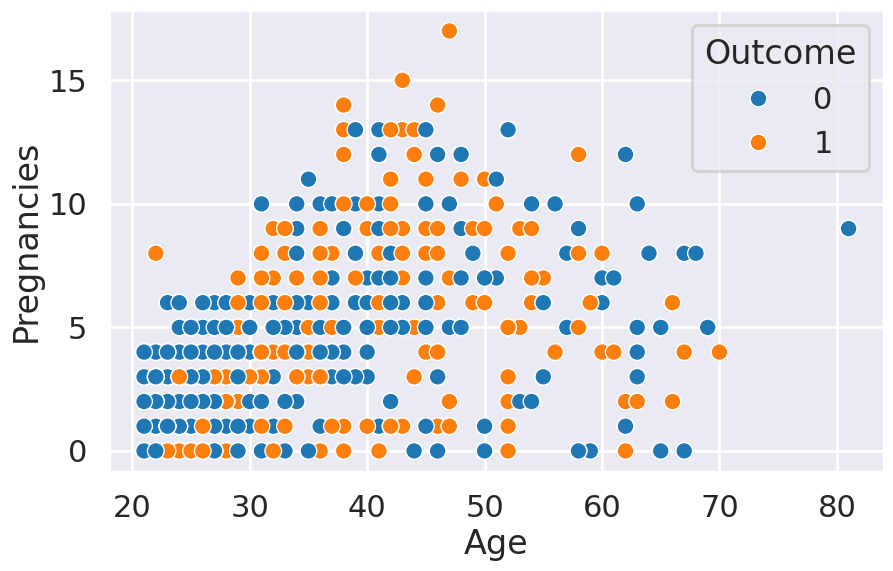

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(data = df, x='Age', y = 'Pregnancies', hue='Outcome')
sns.set_palette("colorblind")
plt.show()

In [16]:
from scipy.stats import spearmanr
coef, p = spearmanr(df['Pregnancies'], df['Age'])
print(f"Коэффициент корреляции Спирмена между кол-вом беременностей и возрастом: {coef}, P-value: {p}")

Коэффициент корреляции Спирмена между кол-вом беременностей и возрастом: 0.6068347308907017, P-value: 2.488067131874704e-190


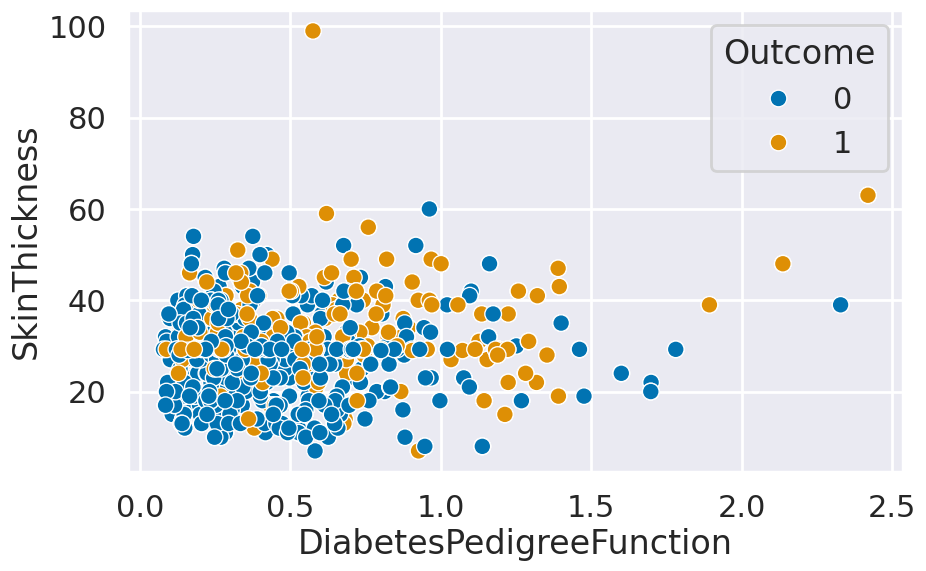

In [17]:
plt.figure(figsize=(10,6))
sns.scatterplot(data = df, x='DiabetesPedigreeFunction', y = 'SkinThickness', hue='Outcome')
plt.show()

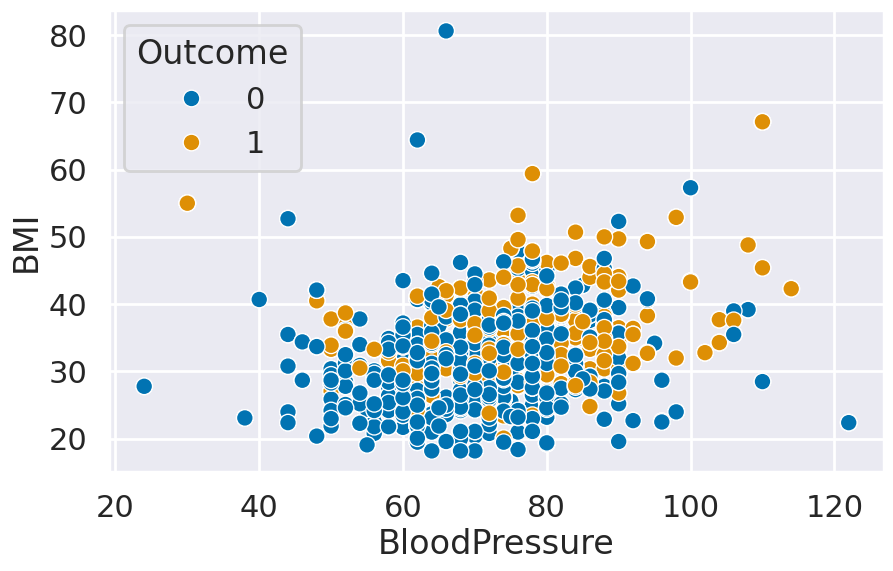

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(data = df, x='BloodPressure', y = 'BMI', hue='Outcome')
plt.show()

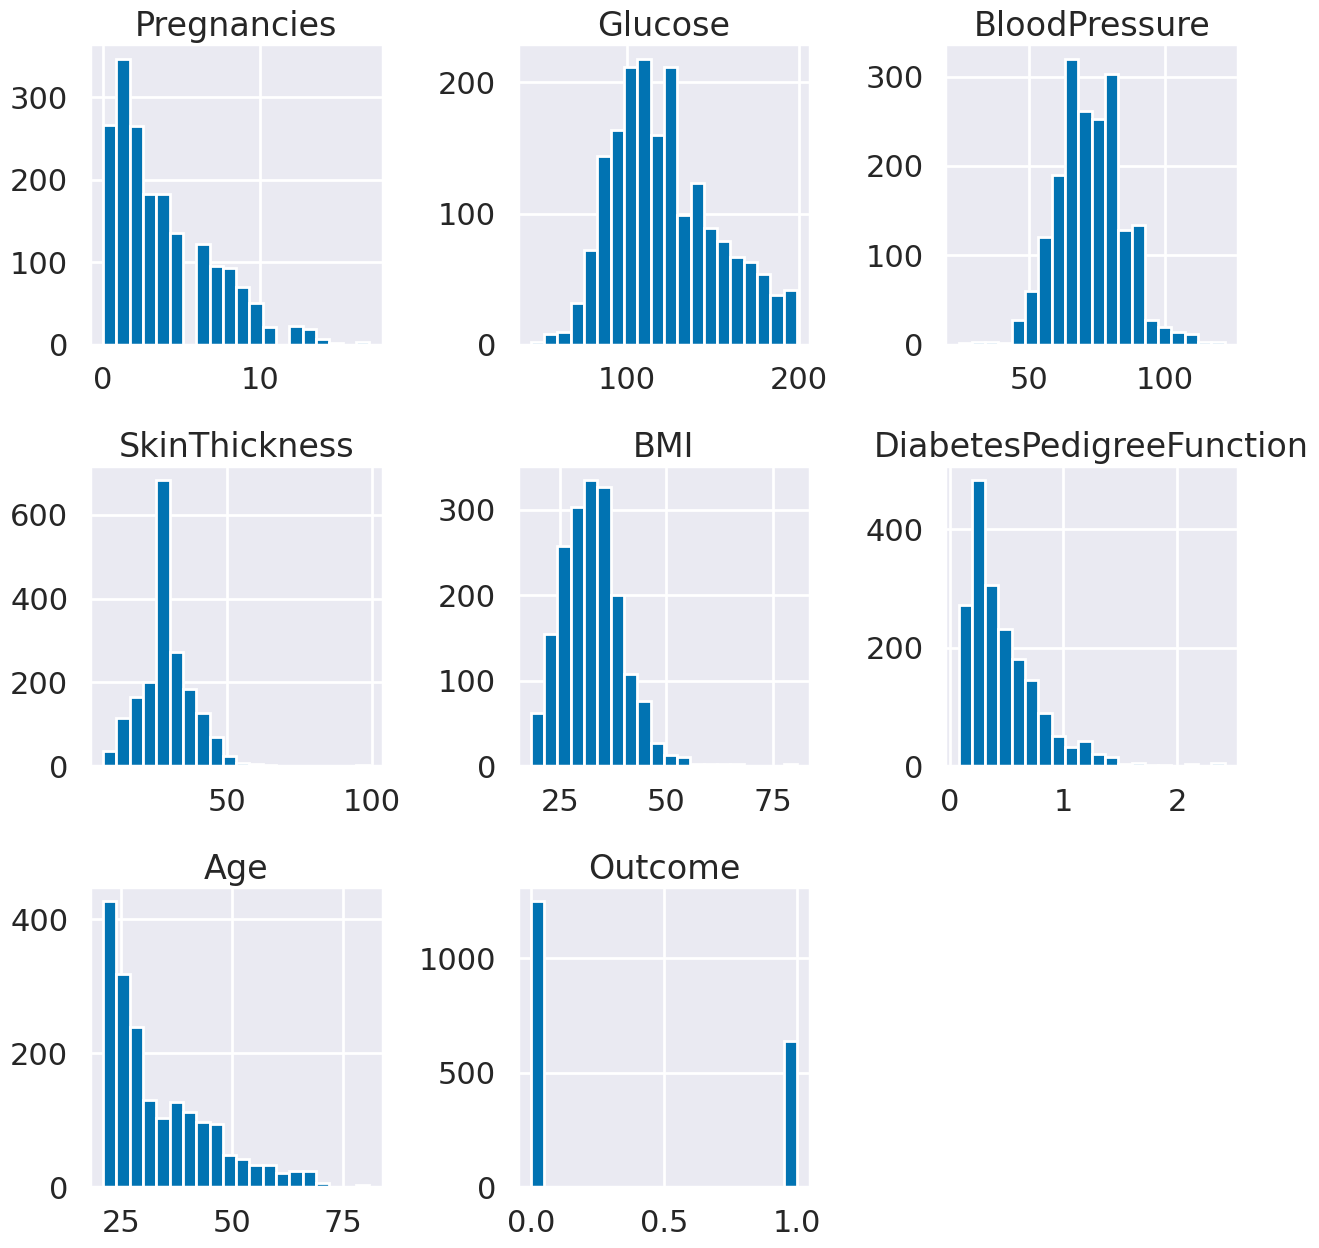

In [19]:
# Генерирует гистограммы для всех числовых столбцов в DataFrame
df.hist(figsize=(13, 13), bins=20)
plt.tight_layout() # Улучшает размещение подграфиков чтобы они не пересекались
plt.show()

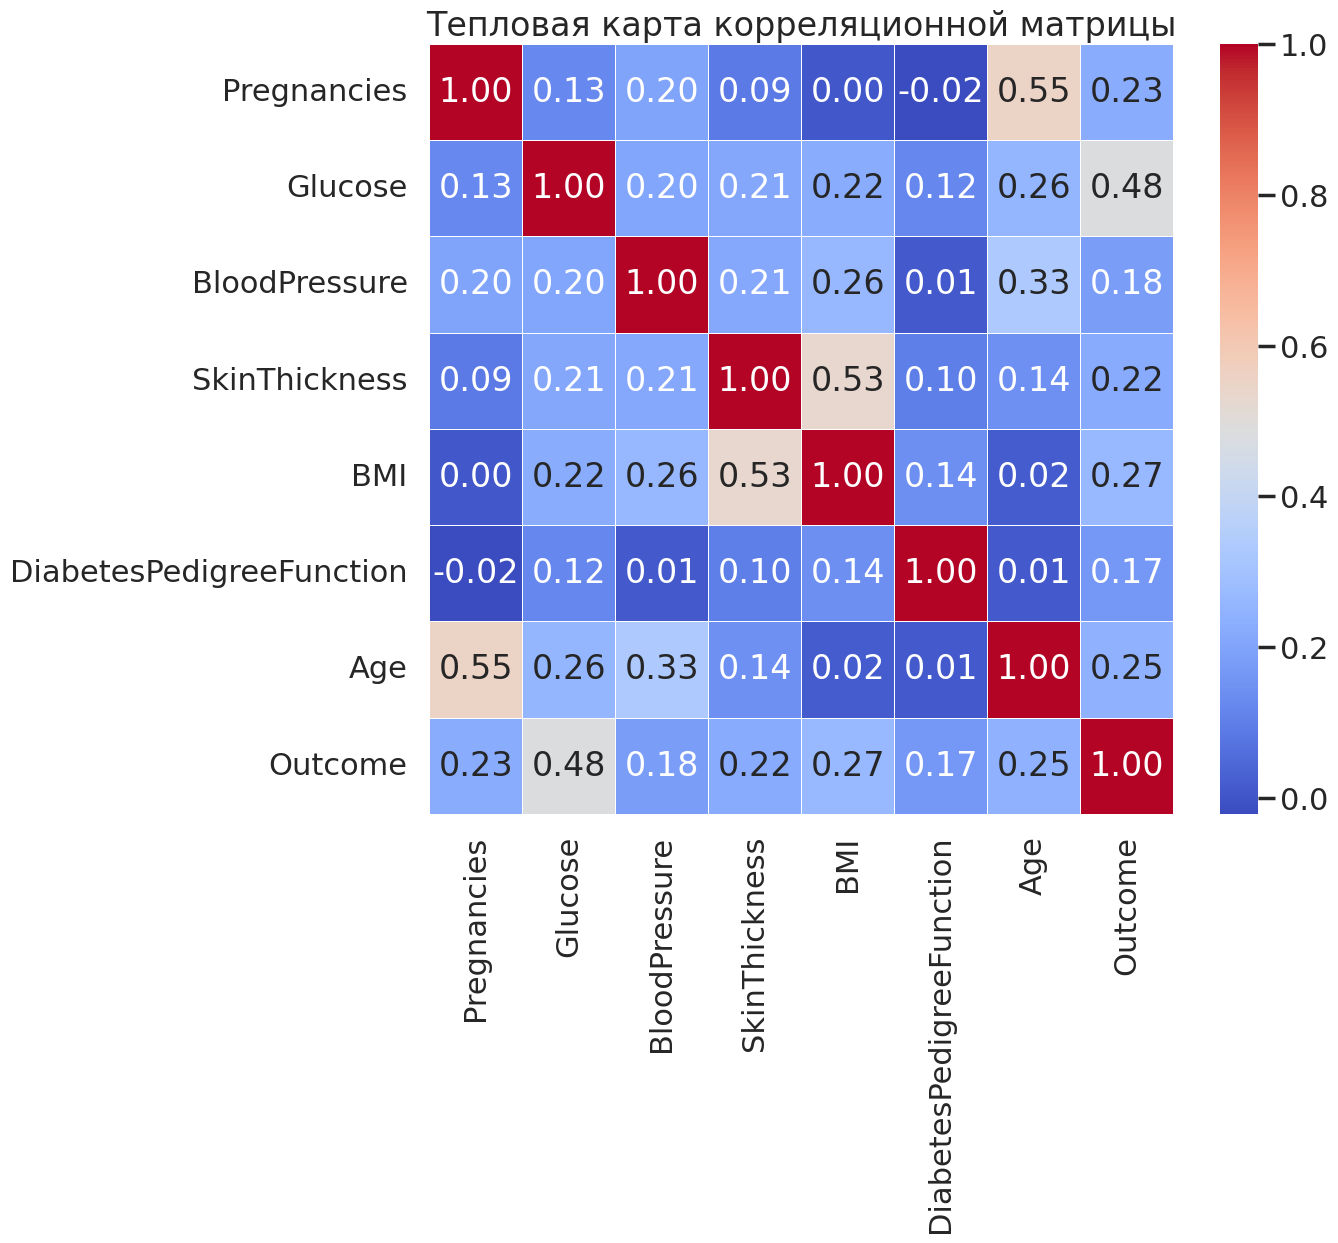

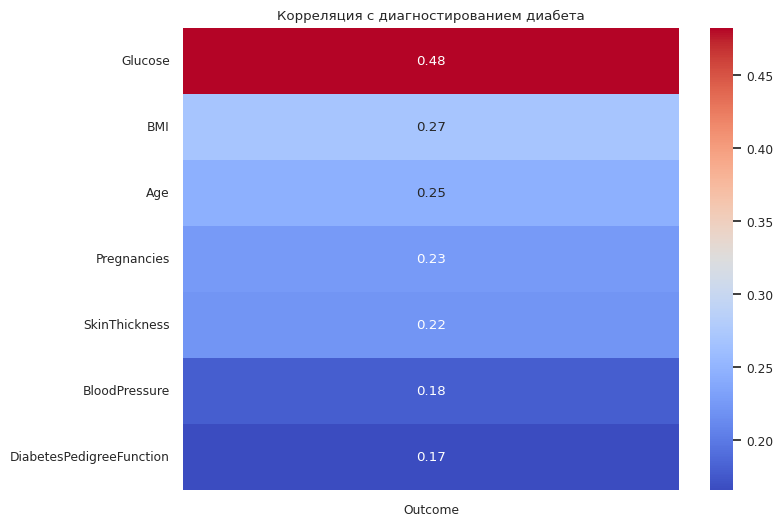

In [20]:
correlation_matrix = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title("Тепловая карта корреляционной матрицы")
plt.show()

corr = df.corr()
target_corr = corr['Outcome'].drop('Outcome')

target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Корреляция с диагностированием диабета')
plt.show()

Из графиков видно, что на проявление диабета больше всего влияют такие параметры как: уровень глюкозы (по которому в большой степени и выставляется диагноз), ИМТ, возраст.  
Как мы видим на тепловой карте, кол-во беременностей зависит скорее от возраста, чем от чего-либо еще, поэтому занимает высокое место. Также толщина кожной складки скорее связана с ИМТ, тк является еще одним маркером при постановке диагноза "ожирение". Возможно, имеет смысл данные параметры не включать в модель, так как они дублируют друг друга по своей сути. На графике мы видели, что в целом как таковое то же количество беременностей ни о чем не говорит.

2. Построение модели:  
— Используя алгоритм логистической регрессии, постройте модель бинарной классификации для предсказания наличия диабета у пациентов.  
— Обучите модель на обучающем наборе данных.  

In [21]:
from sklearn.metrics import accuracy_score

In [22]:
X = df[['BMI', 'Glucose']]  # Выбираем признаки
y = df['Outcome']  # Целевая переменная

X_train, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
model1 = LogisticRegression(class_weight='balanced')
model1.fit(X_train, y_train)

predictions = model1.predict(X_test1)
accuracy1 = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy1)

Accuracy: 0.7142857142857143


In [24]:
X = df[['BMI', 'Glucose', 'Age']]
y = df['Outcome']

X_train, X_test2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
model2 = LogisticRegression(class_weight='balanced')
model2.fit(X_train, y_train)

predictions = model2.predict(X_test2)
accuracy2 = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy2)

Accuracy: 0.7301587301587301


In [26]:
X = df[['BMI', 'Glucose', 'Age', 'BloodPressure']]
y = df['Outcome']

X_train, X_test3, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model3 = LogisticRegression(class_weight='balanced')
model3.fit(X_train, y_train)

predictions = model3.predict(X_test3)
accuracy3 = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy3)

Accuracy: 0.7301587301587301


In [28]:
X = df[['BMI', 'Glucose', 'Age', 'BloodPressure', 'SkinThickness', 'Pregnancies']]
y = df['Outcome']

X_train, X_test4, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model4 = LogisticRegression(class_weight='balanced')
model4.fit(X_train, y_train)

predictions = model4.predict(X_test4)
accuracy4 = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy4)

Accuracy: 0.7380952380952381


Сначала с каждым добавленным параметром точность нашей модели росла, однако параметры 'BMI', 'Glucose', 'Age' кажутся ключевыми, добавление давления, толщины кожной складки и кол-ва беременностей не существенно улучшают точность. Я подозреваю, что на самом деле толщина кожной складки и беременности даже скорее портят нашу модель.

In [30]:
X = df.drop(["Outcome", "Pregnancies", 'SkinThickness'], axis=1)
y = df["Outcome"]
X_train, X_test5, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model5 = LogisticRegression(class_weight='balanced')
model5.fit(X_train, y_train)

predictions = model5.predict(X_test5)
accuracy5 = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy5)

Accuracy: 0.7592592592592593


И действительно, без этих признаков, но с неким коэффициентом отображающим семейный анамнез модель стала более точной.

3. Оценка модели:  
— Вычислите и проанализируйте метрики точности (accuracy), точности (precision), полноты (recall) и F1-меру для обученной модели на тестовых данных.

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
models = {
    'Model 1': model1,
    'Model 2': model2,
    'Model 3': model3,
    'Model 4': model4,
    'Model 5': model5
}

test_datasets = {
    'Model 1': X_test1,
    'Model 2': X_test2,
    'Model 3': X_test3,
    'Model 4': X_test4,
    'Model 5': X_test5
}

results = []

for model_name, model in models.items():
    X_test = test_datasets[model_name]
    y_pred = model.predict(X_test)
    scores = [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='binary'),
        recall_score(y_test, y_pred, average='binary'),
        f1_score(y_test, y_pred, average='binary')
    ]
    results.append(scores)

# Создаем DataFrame для результатов
results_df = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1'], index=models.keys())

In [33]:
results_df

,Accuracy,Precision,Recall,F1
Model 1,0.714286,0.577236,0.559055,0.568000
Model 2,0.730159,0.598425,0.598425,0.598425
Model 3,0.730159,0.598425,0.598425,0.598425
Model 4,0.738095,0.600000,0.661417,0.629213
Model 5,0.759259,0.634328,0.669291,0.651341


In [34]:
from sklearn.metrics import classification_report
print(classification_report(y_test, model5.predict(X_test5)))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       251
           1       0.63      0.67      0.65       127

    accuracy                           0.76       378
   macro avg       0.73      0.74      0.73       378
weighted avg       0.76      0.76      0.76       378



Таблица подтверждает, что модель с каждой попыткой становилась все точнее, повышалось значение каждой метрики. Точность 76% кажется мне неплохим результатом. Если посмотреть, как точна модель для каждого из классов, очевидно, что для класса диабет + модель менее точна, так как и данные были распределены не равномерно. Тем не менее, результаты относительно приемлемы.  
В данном случае мы проводили анализ, чтобы по имеющимся параметрам выделять группу риска: людей с предрасположенностью к диабету. Диабет - страшное заболевание, особенно если говорить о типе 1. Его легко можно не заметить, часто человек впадает в кому и вот тут то и выясняется его диагноз.  
Я полагаю, в данном случае важнее ориентироваться на параметр recall (полнота), так как важнее охватить всех людей, которые могут находиться под угрозой, а снять ложно положительное предсказание довольно легко. Исследования не дороги и весьма доступны, уровень глюкозы можно измерить даже дома. Так что плата за ложно положительный результат довольно низка, а вот пропустить хотя бы одного человека - весьма дорого (и лечение его, если потребуется реанимация, будет стоить фонду ОМС сотни тысяч).

# Применение CatBoost

In [39]:
pip install catboost

In [40]:
from catboost import CatBoostClassifier


In [41]:
X = df.drop(["Outcome", "Pregnancies", 'SkinThickness'], axis=1)
y = df["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6)
model.fit(X_train, y_train)

0:	learn: 0.6461119	total: 69.3ms	remaining: 1m 9s
1:	learn: 0.6017291	total: 87ms	remaining: 43.4s
2:	learn: 0.5690937	total: 100ms	remaining: 33.4s
3:	learn: 0.5388066	total: 115ms	remaining: 28.6s
4:	learn: 0.5162977	total: 119ms	remaining: 23.7s
5:	learn: 0.4964039	total: 123ms	remaining: 20.4s
6:	learn: 0.4791370	total: 130ms	remaining: 18.5s
7:	learn: 0.4638622	total: 138ms	remaining: 17.1s
8:	learn: 0.4503406	total: 141ms	remaining: 15.6s
9:	learn: 0.4409371	total: 155ms	remaining: 15.3s
10:	learn: 0.4342257	total: 158ms	remaining: 14.2s
11:	learn: 0.4211470	total: 164ms	remaining: 13.5s
12:	learn: 0.4156401	total: 167ms	remaining: 12.7s
13:	learn: 0.4072120	total: 174ms	remaining: 12.3s
14:	learn: 0.4013991	total: 185ms	remaining: 12.1s
15:	learn: 0.3932530	total: 196ms	remaining: 12s
16:	learn: 0.3879542	total: 203ms	remaining: 11.7s
17:	learn: 0.3832104	total: 206ms	remaining: 11.2s
18:	learn: 0.3761696	total: 220ms	remaining: 11.3s
19:	learn: 0.3709016	total: 224ms	remaining

In [43]:
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9682539682539683


CatBoost дает точность 0.968, что существенно выше любого варианта логистической регрессии